In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

import corner

In [2]:
from starccato_flow.data.ccsn_snr_data import CCSNSNRData
from starccato_flow.data.toy_data import ToyData
from starccato_flow.training.trainer import Trainer
from starccato_flow.training.trainer_flow_matching import FlowMatchingTrainer

from starccato_flow.utils.defaults import TEN_KPC
from starccato_flow.plotting.plotting import plot_reconstruction_distribution, plot_candidate_signal, create_latent_morph_gif

/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MPS device found


/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from starccato_flow.utils.defaults import DEVICE

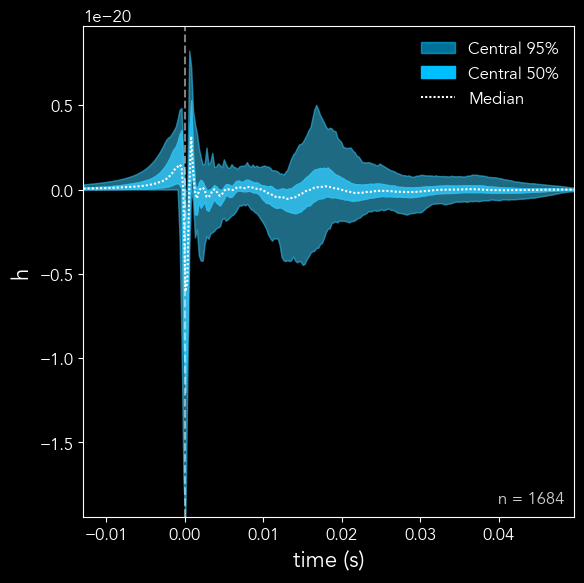

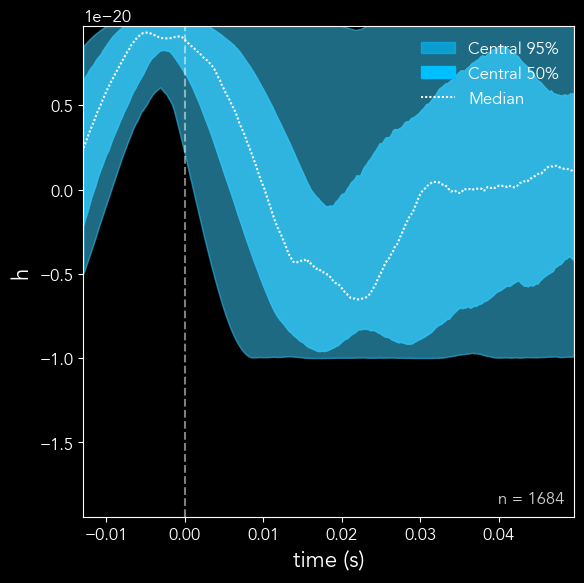

In [4]:
ccsn_dataset = CCSNSNRData(noise=True, curriculum=False)
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_distribution.svg")

toy_dataset = ToyData(noise=False, curriculum=False)
toy_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/toy_signal_distribution.svg")

In [5]:
trainer = FlowMatchingTrainer(
    toy=True, 
    start_snr=200,
    end_snr=10,
    noise=False, 
    validation_split=0.1,
    curriculum=True,
    noise_realizations=1
)

# trainer.plot_candidate_signal(
#     snr=30,
#     index=60,
#     background="black"
# )


=== Toy Data Split ===
Total signals: 256
Training signals: 231
Validation signals: 25

Verifying data alignment:
Number of signals: 231
Number of parameter sets: 231

Verifying data alignment:
Number of signals: 25
Number of parameter sets: 25

=== Dataset Sizes ===
Training samples: 231
Validation samples: 25


In [6]:
trainer.train()

Epochs:   1%|          | 3/256 [00:00<00:40,  6.25it/s]

Epoch 1/256 | Train MSE Loss: 0.4757 | Val MSE Loss: 0.0791
Epoch 2/256 | Train MSE Loss: 0.0666 | Val MSE Loss: 0.0708
Epoch 3/256 | Train MSE Loss: 0.0509 | Val MSE Loss: 0.0513
Epoch 4/256 | Train MSE Loss: 0.0550 | Val MSE Loss: 0.0635


Epochs:   3%|▎         | 7/256 [00:00<00:22, 11.07it/s]

Epoch 5/256 | Train MSE Loss: 0.0493 | Val MSE Loss: 0.0710
Epoch 6/256 | Train MSE Loss: 0.0524 | Val MSE Loss: 0.0468
Epoch 7/256 | Train MSE Loss: 0.0463 | Val MSE Loss: 0.0405
Epoch 8/256 | Train MSE Loss: 0.0490 | Val MSE Loss: 0.0756


Epochs:   4%|▍         | 11/256 [00:01<00:18, 13.58it/s]

Epoch 9/256 | Train MSE Loss: 0.0517 | Val MSE Loss: 0.0233
Epoch 10/256 | Train MSE Loss: 0.0369 | Val MSE Loss: 0.0409
Epoch 11/256 | Train MSE Loss: 0.0392 | Val MSE Loss: 0.0355
Epoch 12/256 | Train MSE Loss: 0.0314 | Val MSE Loss: 0.0443


Epochs:   6%|▌         | 15/256 [00:01<00:16, 14.52it/s]

Epoch 13/256 | Train MSE Loss: 0.0420 | Val MSE Loss: 0.0324
Epoch 14/256 | Train MSE Loss: 0.0374 | Val MSE Loss: 0.0305
Epoch 15/256 | Train MSE Loss: 0.0306 | Val MSE Loss: 0.0406
Epoch 16/256 | Train MSE Loss: 0.0297 | Val MSE Loss: 0.0568


Epochs:   7%|▋         | 19/256 [00:01<00:16, 14.77it/s]

Epoch 17/256 | Train MSE Loss: 0.0306 | Val MSE Loss: 0.0469
Epoch 18/256 | Train MSE Loss: 0.0342 | Val MSE Loss: 0.0265
Epoch 19/256 | Train MSE Loss: 0.0308 | Val MSE Loss: 0.0432
Epoch 20/256 | Train MSE Loss: 0.0365 | Val MSE Loss: 0.0244


Epochs:   9%|▉         | 23/256 [00:01<00:15, 15.10it/s]

Epoch 21/256 | Train MSE Loss: 0.0252 | Val MSE Loss: 0.0300
Epoch 22/256 | Train MSE Loss: 0.0271 | Val MSE Loss: 0.0484
Epoch 23/256 | Train MSE Loss: 0.0286 | Val MSE Loss: 0.0418
Epoch 24/256 | Train MSE Loss: 0.0322 | Val MSE Loss: 0.0434


Epochs:  11%|█         | 27/256 [00:02<00:15, 15.12it/s]

Epoch 25/256 | Train MSE Loss: 0.0305 | Val MSE Loss: 0.0291
Epoch 26/256 | Train MSE Loss: 0.0231 | Val MSE Loss: 0.0326
Epoch 27/256 | Train MSE Loss: 0.0289 | Val MSE Loss: 0.0395
Epoch 28/256 | Train MSE Loss: 0.0265 | Val MSE Loss: 0.0398


Epochs:  12%|█▏        | 31/256 [00:02<00:14, 15.47it/s]

Epoch 29/256 | Train MSE Loss: 0.0290 | Val MSE Loss: 0.0255
Epoch 30/256 | Train MSE Loss: 0.0228 | Val MSE Loss: 0.0198
Epoch 31/256 | Train MSE Loss: 0.0243 | Val MSE Loss: 0.0184
Epoch 32/256 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0224


Epochs:  14%|█▎        | 35/256 [00:02<00:14, 15.54it/s]

Epoch 33/256 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0169
Epoch 34/256 | Train MSE Loss: 0.0215 | Val MSE Loss: 0.0356
Epoch 35/256 | Train MSE Loss: 0.0215 | Val MSE Loss: 0.0412
Epoch 36/256 | Train MSE Loss: 0.0249 | Val MSE Loss: 0.0242


Epochs:  15%|█▌        | 39/256 [00:02<00:13, 15.55it/s]

Epoch 37/256 | Train MSE Loss: 0.0217 | Val MSE Loss: 0.0242
Epoch 38/256 | Train MSE Loss: 0.0197 | Val MSE Loss: 0.0199
Epoch 39/256 | Train MSE Loss: 0.0132 | Val MSE Loss: 0.0305
Epoch 40/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0198


Epochs:  17%|█▋        | 43/256 [00:03<00:13, 15.58it/s]

Epoch 41/256 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0272
Epoch 42/256 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0174
Epoch 43/256 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0167
Epoch 44/256 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0104


Epochs:  18%|█▊        | 47/256 [00:03<00:13, 15.48it/s]

Epoch 45/256 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0154
Epoch 46/256 | Train MSE Loss: 0.0113 | Val MSE Loss: 0.0098
Epoch 47/256 | Train MSE Loss: 0.0128 | Val MSE Loss: 0.0205
Epoch 48/256 | Train MSE Loss: 0.0118 | Val MSE Loss: 0.0219


Epochs:  20%|█▉        | 51/256 [00:03<00:13, 15.54it/s]

Epoch 49/256 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0214
Epoch 50/256 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0158
Epoch 51/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0122
Epoch 52/256 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0207


Epochs:  21%|██▏       | 55/256 [00:03<00:12, 15.53it/s]

Epoch 53/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0182
Epoch 54/256 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0292
Epoch 55/256 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0216
Epoch 56/256 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0210


Epochs:  23%|██▎       | 59/256 [00:04<00:12, 15.48it/s]

Epoch 57/256 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0145
Epoch 58/256 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0118
Epoch 59/256 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0237


Epochs:  25%|██▍       | 63/256 [00:04<00:12, 15.33it/s]

Epoch 60/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0214
Epoch 61/256 | Train MSE Loss: 0.0177 | Val MSE Loss: 0.0232
Epoch 62/256 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0131
Epoch 63/256 | Train MSE Loss: 0.0112 | Val MSE Loss: 0.0175


Epochs:  25%|██▌       | 65/256 [00:04<00:12, 15.11it/s]

Epoch 64/256 | Train MSE Loss: 0.0128 | Val MSE Loss: 0.0153
Epoch 65/256 | Train MSE Loss: 0.0138 | Val MSE Loss: 0.0330
Epoch 66/256 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0312


Epochs:  27%|██▋       | 69/256 [00:04<00:12, 14.61it/s]

Epoch 67/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0127
Epoch 68/256 | Train MSE Loss: 0.0145 | Val MSE Loss: 0.0158
Epoch 69/256 | Train MSE Loss: 0.0132 | Val MSE Loss: 0.0159


Epochs:  29%|██▊       | 73/256 [00:05<00:12, 14.98it/s]

Epoch 70/256 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0200
Epoch 71/256 | Train MSE Loss: 0.0116 | Val MSE Loss: 0.0080
Epoch 72/256 | Train MSE Loss: 0.0117 | Val MSE Loss: 0.0191
Epoch 73/256 | Train MSE Loss: 0.0111 | Val MSE Loss: 0.0138


Epochs:  30%|███       | 77/256 [00:05<00:11, 15.04it/s]

Epoch 74/256 | Train MSE Loss: 0.0142 | Val MSE Loss: 0.0150
Epoch 75/256 | Train MSE Loss: 0.0114 | Val MSE Loss: 0.0233
Epoch 76/256 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0120
Epoch 77/256 | Train MSE Loss: 0.0120 | Val MSE Loss: 0.0219


Epochs:  32%|███▏      | 81/256 [00:05<00:11, 15.33it/s]

Epoch 78/256 | Train MSE Loss: 0.0110 | Val MSE Loss: 0.0359
Epoch 79/256 | Train MSE Loss: 0.0168 | Val MSE Loss: 0.0210
Epoch 80/256 | Train MSE Loss: 0.0145 | Val MSE Loss: 0.0221
Epoch 81/256 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0104


Epochs:  33%|███▎      | 85/256 [00:05<00:11, 15.36it/s]

Epoch 82/256 | Train MSE Loss: 0.0145 | Val MSE Loss: 0.0125
Epoch 83/256 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0139
Epoch 84/256 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0209
Epoch 85/256 | Train MSE Loss: 0.0201 | Val MSE Loss: 0.0122


Epochs:  35%|███▍      | 89/256 [00:06<00:10, 15.65it/s]

Epoch 86/256 | Train MSE Loss: 0.0123 | Val MSE Loss: 0.0120
Epoch 87/256 | Train MSE Loss: 0.0120 | Val MSE Loss: 0.0162
Epoch 88/256 | Train MSE Loss: 0.0132 | Val MSE Loss: 0.0088
Epoch 89/256 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0326


Epochs:  36%|███▋      | 93/256 [00:06<00:10, 15.47it/s]

Epoch 90/256 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0102
Epoch 91/256 | Train MSE Loss: 0.0120 | Val MSE Loss: 0.0109
Epoch 92/256 | Train MSE Loss: 0.0130 | Val MSE Loss: 0.0118
Epoch 93/256 | Train MSE Loss: 0.0100 | Val MSE Loss: 0.0155


Epochs:  38%|███▊      | 97/256 [00:06<00:10, 15.22it/s]

Epoch 94/256 | Train MSE Loss: 0.0143 | Val MSE Loss: 0.0121
Epoch 95/256 | Train MSE Loss: 0.0127 | Val MSE Loss: 0.0070
Epoch 96/256 | Train MSE Loss: 0.0123 | Val MSE Loss: 0.0113
Epoch 97/256 | Train MSE Loss: 0.0117 | Val MSE Loss: 0.0161


Epochs:  39%|███▉      | 101/256 [00:06<00:10, 15.22it/s]

Epoch 98/256 | Train MSE Loss: 0.0131 | Val MSE Loss: 0.0142
Epoch 99/256 | Train MSE Loss: 0.0089 | Val MSE Loss: 0.0092
Epoch 100/256 | Train MSE Loss: 0.0096 | Val MSE Loss: 0.0096
Epoch 101/256 | Train MSE Loss: 0.0116 | Val MSE Loss: 0.0178


Epochs:  40%|████      | 103/256 [00:07<00:10, 14.91it/s]

Epoch 102/256 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0119
Epoch 103/256 | Train MSE Loss: 0.0121 | Val MSE Loss: 0.0180
Epoch 104/256 | Train MSE Loss: 0.0125 | Val MSE Loss: 0.0296


Epochs:  42%|████▏     | 107/256 [00:07<00:10, 14.87it/s]

Epoch 105/256 | Train MSE Loss: 0.0218 | Val MSE Loss: 0.0140
Epoch 106/256 | Train MSE Loss: 0.0129 | Val MSE Loss: 0.0156
Epoch 107/256 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0140


Epochs:  43%|████▎     | 111/256 [00:07<00:09, 15.02it/s]

Epoch 108/256 | Train MSE Loss: 0.0098 | Val MSE Loss: 0.0153
Epoch 109/256 | Train MSE Loss: 0.0139 | Val MSE Loss: 0.0263
Epoch 110/256 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0115
Epoch 111/256 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0139


Epochs:  45%|████▍     | 115/256 [00:07<00:09, 14.99it/s]

Epoch 112/256 | Train MSE Loss: 0.0128 | Val MSE Loss: 0.0224
Epoch 113/256 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0194
Epoch 114/256 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0210
Epoch 115/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0131


Epochs:  46%|████▋     | 119/256 [00:08<00:09, 14.99it/s]

Epoch 116/256 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0175
Epoch 117/256 | Train MSE Loss: 0.0126 | Val MSE Loss: 0.0104
Epoch 118/256 | Train MSE Loss: 0.0123 | Val MSE Loss: 0.0268
Epoch 119/256 | Train MSE Loss: 0.0110 | Val MSE Loss: 0.0078


Epochs:  48%|████▊     | 123/256 [00:08<00:08, 15.34it/s]

Epoch 120/256 | Train MSE Loss: 0.0105 | Val MSE Loss: 0.0113
Epoch 121/256 | Train MSE Loss: 0.0116 | Val MSE Loss: 0.0177
Epoch 122/256 | Train MSE Loss: 0.0135 | Val MSE Loss: 0.0157
Epoch 123/256 | Train MSE Loss: 0.0101 | Val MSE Loss: 0.0098


Epochs:  50%|████▉     | 127/256 [00:08<00:08, 15.34it/s]

Epoch 124/256 | Train MSE Loss: 0.0115 | Val MSE Loss: 0.0154
Epoch 125/256 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0109
Epoch 126/256 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0094
Epoch 127/256 | Train MSE Loss: 0.0138 | Val MSE Loss: 0.0122


Epochs:  51%|█████     | 131/256 [00:08<00:08, 15.12it/s]

Epoch 128/256 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0133
Epoch 129/256 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0242
Epoch 130/256 | Train MSE Loss: 0.0116 | Val MSE Loss: 0.0104
Epoch 131/256 | Train MSE Loss: 0.0118 | Val MSE Loss: 0.0134


Epochs:  53%|█████▎    | 135/256 [00:09<00:08, 15.12it/s]

Epoch 132/256 | Train MSE Loss: 0.0130 | Val MSE Loss: 0.0145
Epoch 133/256 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0246
Epoch 134/256 | Train MSE Loss: 0.0144 | Val MSE Loss: 0.0070
Epoch 135/256 | Train MSE Loss: 0.0114 | Val MSE Loss: 0.0086


Epochs:  54%|█████▍    | 139/256 [00:09<00:07, 15.07it/s]

Epoch 136/256 | Train MSE Loss: 0.0110 | Val MSE Loss: 0.0124
Epoch 137/256 | Train MSE Loss: 0.0111 | Val MSE Loss: 0.0145
Epoch 138/256 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0067
Epoch 139/256 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0254


Epochs:  56%|█████▌    | 143/256 [00:09<00:07, 15.10it/s]

Epoch 140/256 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0154
Epoch 141/256 | Train MSE Loss: 0.0133 | Val MSE Loss: 0.0222
Epoch 142/256 | Train MSE Loss: 0.0177 | Val MSE Loss: 0.0271
Epoch 143/256 | Train MSE Loss: 0.0136 | Val MSE Loss: 0.0223


Epochs:  57%|█████▋    | 147/256 [00:10<00:07, 15.18it/s]

Epoch 144/256 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0133
Epoch 145/256 | Train MSE Loss: 0.0105 | Val MSE Loss: 0.0104
Epoch 146/256 | Train MSE Loss: 0.0102 | Val MSE Loss: 0.0152
Epoch 147/256 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0115


Epochs:  59%|█████▉    | 151/256 [00:10<00:06, 15.35it/s]

Epoch 148/256 | Train MSE Loss: 0.0115 | Val MSE Loss: 0.0226
Epoch 149/256 | Train MSE Loss: 0.0111 | Val MSE Loss: 0.0223
Epoch 150/256 | Train MSE Loss: 0.0118 | Val MSE Loss: 0.0142
Epoch 151/256 | Train MSE Loss: 0.0111 | Val MSE Loss: 0.0189


Epochs:  61%|██████    | 155/256 [00:10<00:06, 15.33it/s]

Epoch 152/256 | Train MSE Loss: 0.0107 | Val MSE Loss: 0.0146
Epoch 153/256 | Train MSE Loss: 0.0099 | Val MSE Loss: 0.0190
Epoch 154/256 | Train MSE Loss: 0.0117 | Val MSE Loss: 0.0196
Epoch 155/256 | Train MSE Loss: 0.0082 | Val MSE Loss: 0.0149


Epochs:  62%|██████▏   | 159/256 [00:10<00:06, 15.11it/s]

Epoch 156/256 | Train MSE Loss: 0.0099 | Val MSE Loss: 0.0156
Epoch 157/256 | Train MSE Loss: 0.0135 | Val MSE Loss: 0.0094
Epoch 158/256 | Train MSE Loss: 0.0096 | Val MSE Loss: 0.0112
Epoch 159/256 | Train MSE Loss: 0.0120 | Val MSE Loss: 0.0143


Epochs:  64%|██████▎   | 163/256 [00:11<00:06, 15.19it/s]

Epoch 160/256 | Train MSE Loss: 0.0112 | Val MSE Loss: 0.0086
Epoch 161/256 | Train MSE Loss: 0.0111 | Val MSE Loss: 0.0179
Epoch 162/256 | Train MSE Loss: 0.0099 | Val MSE Loss: 0.0083
Epoch 163/256 | Train MSE Loss: 0.0141 | Val MSE Loss: 0.0431


Epochs:  65%|██████▌   | 167/256 [00:11<00:05, 15.20it/s]

Epoch 164/256 | Train MSE Loss: 0.0206 | Val MSE Loss: 0.0205
Epoch 165/256 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0219
Epoch 166/256 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0097
Epoch 167/256 | Train MSE Loss: 0.0143 | Val MSE Loss: 0.0263


Epochs:  66%|██████▌   | 169/256 [00:11<00:05, 15.16it/s]

Epoch 168/256 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0136
Epoch 169/256 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0163
Epoch 170/256 | Train MSE Loss: 0.0131 | Val MSE Loss: 0.0158


Epochs:  68%|██████▊   | 173/256 [00:11<00:05, 15.13it/s]

Epoch 171/256 | Train MSE Loss: 0.0129 | Val MSE Loss: 0.0180
Epoch 172/256 | Train MSE Loss: 0.0141 | Val MSE Loss: 0.0108
Epoch 173/256 | Train MSE Loss: 0.0129 | Val MSE Loss: 0.0217
Epoch 174/256 | Train MSE Loss: 0.0101 | Val MSE Loss: 0.0068


Epochs:  69%|██████▉   | 177/256 [00:11<00:05, 15.16it/s]

Epoch 175/256 | Train MSE Loss: 0.0129 | Val MSE Loss: 0.0157
Epoch 176/256 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0193
Epoch 177/256 | Train MSE Loss: 0.0208 | Val MSE Loss: 0.0261
Epoch 178/256 | Train MSE Loss: 0.0136 | Val MSE Loss: 0.0105


Epochs:  71%|███████   | 181/256 [00:12<00:04, 15.40it/s]

Epoch 179/256 | Train MSE Loss: 0.0115 | Val MSE Loss: 0.0115
Epoch 180/256 | Train MSE Loss: 0.0118 | Val MSE Loss: 0.0098
Epoch 181/256 | Train MSE Loss: 0.0090 | Val MSE Loss: 0.0100
Epoch 182/256 | Train MSE Loss: 0.0114 | Val MSE Loss: 0.0061


Epochs:  72%|███████▏  | 185/256 [00:12<00:04, 15.71it/s]

Epoch 183/256 | Train MSE Loss: 0.0101 | Val MSE Loss: 0.0098
Epoch 184/256 | Train MSE Loss: 0.0097 | Val MSE Loss: 0.0102
Epoch 185/256 | Train MSE Loss: 0.0125 | Val MSE Loss: 0.0197
Epoch 186/256 | Train MSE Loss: 0.0124 | Val MSE Loss: 0.0095


Epochs:  74%|███████▍  | 189/256 [00:12<00:04, 15.35it/s]

Epoch 187/256 | Train MSE Loss: 0.0134 | Val MSE Loss: 0.0106
Epoch 188/256 | Train MSE Loss: 0.0098 | Val MSE Loss: 0.0150
Epoch 189/256 | Train MSE Loss: 0.0123 | Val MSE Loss: 0.0110
Epoch 190/256 | Train MSE Loss: 0.0101 | Val MSE Loss: 0.0102


Epochs:  75%|███████▌  | 193/256 [00:12<00:03, 16.09it/s]

Epoch 191/256 | Train MSE Loss: 0.0131 | Val MSE Loss: 0.0137
Epoch 192/256 | Train MSE Loss: 0.0090 | Val MSE Loss: 0.0116
Epoch 193/256 | Train MSE Loss: 0.0087 | Val MSE Loss: 0.0129
Epoch 194/256 | Train MSE Loss: 0.0073 | Val MSE Loss: 0.0086


Epochs:  77%|███████▋  | 197/256 [00:13<00:03, 16.36it/s]

Epoch 195/256 | Train MSE Loss: 0.0086 | Val MSE Loss: 0.0224
Epoch 196/256 | Train MSE Loss: 0.0117 | Val MSE Loss: 0.0104
Epoch 197/256 | Train MSE Loss: 0.0131 | Val MSE Loss: 0.0177
Epoch 198/256 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0169


Epochs:  79%|███████▊  | 201/256 [00:13<00:03, 16.20it/s]

Epoch 199/256 | Train MSE Loss: 0.0128 | Val MSE Loss: 0.0099
Epoch 200/256 | Train MSE Loss: 0.0106 | Val MSE Loss: 0.0209
Epoch 201/256 | Train MSE Loss: 0.0104 | Val MSE Loss: 0.0108
Epoch 202/256 | Train MSE Loss: 0.0088 | Val MSE Loss: 0.0057


Epochs:  80%|████████  | 205/256 [00:13<00:03, 15.54it/s]

Epoch 203/256 | Train MSE Loss: 0.0083 | Val MSE Loss: 0.0110
Epoch 204/256 | Train MSE Loss: 0.0086 | Val MSE Loss: 0.0082
Epoch 205/256 | Train MSE Loss: 0.0077 | Val MSE Loss: 0.0169
Epoch 206/256 | Train MSE Loss: 0.0098 | Val MSE Loss: 0.0133


Epochs:  82%|████████▏ | 209/256 [00:14<00:03, 14.00it/s]

Epoch 207/256 | Train MSE Loss: 0.0118 | Val MSE Loss: 0.0106
Epoch 208/256 | Train MSE Loss: 0.0081 | Val MSE Loss: 0.0096
Epoch 209/256 | Train MSE Loss: 0.0094 | Val MSE Loss: 0.0152


Epochs:  82%|████████▏ | 211/256 [00:14<00:03, 14.04it/s]

Epoch 210/256 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0235
Epoch 211/256 | Train MSE Loss: 0.0206 | Val MSE Loss: 0.0307
Epoch 212/256 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0134


Epochs:  84%|████████▍ | 215/256 [00:14<00:02, 14.39it/s]

Epoch 213/256 | Train MSE Loss: 0.0135 | Val MSE Loss: 0.0146
Epoch 214/256 | Train MSE Loss: 0.0134 | Val MSE Loss: 0.0098
Epoch 215/256 | Train MSE Loss: 0.0132 | Val MSE Loss: 0.0169


Epochs:  86%|████████▌ | 219/256 [00:14<00:02, 14.27it/s]

Epoch 216/256 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0091
Epoch 217/256 | Train MSE Loss: 0.0119 | Val MSE Loss: 0.0065
Epoch 218/256 | Train MSE Loss: 0.0098 | Val MSE Loss: 0.0160
Epoch 219/256 | Train MSE Loss: 0.0120 | Val MSE Loss: 0.0149


Epochs:  87%|████████▋ | 223/256 [00:15<00:02, 14.65it/s]

Epoch 220/256 | Train MSE Loss: 0.0136 | Val MSE Loss: 0.0083
Epoch 221/256 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0108
Epoch 222/256 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0124
Epoch 223/256 | Train MSE Loss: 0.0119 | Val MSE Loss: 0.0418


Epochs:  89%|████████▊ | 227/256 [00:15<00:01, 15.04it/s]

Epoch 224/256 | Train MSE Loss: 0.0133 | Val MSE Loss: 0.0099
Epoch 225/256 | Train MSE Loss: 0.0093 | Val MSE Loss: 0.0145
Epoch 226/256 | Train MSE Loss: 0.0082 | Val MSE Loss: 0.0122
Epoch 227/256 | Train MSE Loss: 0.0094 | Val MSE Loss: 0.0151


Epochs:  90%|█████████ | 231/256 [00:15<00:01, 15.37it/s]

Epoch 228/256 | Train MSE Loss: 0.0095 | Val MSE Loss: 0.0074
Epoch 229/256 | Train MSE Loss: 0.0079 | Val MSE Loss: 0.0080
Epoch 230/256 | Train MSE Loss: 0.0086 | Val MSE Loss: 0.0088
Epoch 231/256 | Train MSE Loss: 0.0099 | Val MSE Loss: 0.0131


Epochs:  92%|█████████▏| 235/256 [00:15<00:01, 15.23it/s]

Epoch 232/256 | Train MSE Loss: 0.0130 | Val MSE Loss: 0.0133
Epoch 233/256 | Train MSE Loss: 0.0092 | Val MSE Loss: 0.0138
Epoch 234/256 | Train MSE Loss: 0.0096 | Val MSE Loss: 0.0094
Epoch 235/256 | Train MSE Loss: 0.0082 | Val MSE Loss: 0.0067


Epochs:  93%|█████████▎| 239/256 [00:16<00:01, 15.45it/s]

Epoch 236/256 | Train MSE Loss: 0.0100 | Val MSE Loss: 0.0100
Epoch 237/256 | Train MSE Loss: 0.0109 | Val MSE Loss: 0.0125
Epoch 238/256 | Train MSE Loss: 0.0109 | Val MSE Loss: 0.0106
Epoch 239/256 | Train MSE Loss: 0.0081 | Val MSE Loss: 0.0171


Epochs:  95%|█████████▍| 243/256 [00:16<00:00, 15.43it/s]

Epoch 240/256 | Train MSE Loss: 0.0080 | Val MSE Loss: 0.0137
Epoch 241/256 | Train MSE Loss: 0.0130 | Val MSE Loss: 0.0127
Epoch 242/256 | Train MSE Loss: 0.0118 | Val MSE Loss: 0.0061
Epoch 243/256 | Train MSE Loss: 0.0095 | Val MSE Loss: 0.0130


Epochs:  96%|█████████▋| 247/256 [00:16<00:00, 15.10it/s]

Epoch 244/256 | Train MSE Loss: 0.0109 | Val MSE Loss: 0.0166
Epoch 245/256 | Train MSE Loss: 0.0111 | Val MSE Loss: 0.0125
Epoch 246/256 | Train MSE Loss: 0.0101 | Val MSE Loss: 0.0071
Epoch 247/256 | Train MSE Loss: 0.0111 | Val MSE Loss: 0.0099


Epochs:  98%|█████████▊| 251/256 [00:16<00:00, 15.41it/s]

Epoch 248/256 | Train MSE Loss: 0.0069 | Val MSE Loss: 0.0145
Epoch 249/256 | Train MSE Loss: 0.0101 | Val MSE Loss: 0.0189
Epoch 250/256 | Train MSE Loss: 0.0128 | Val MSE Loss: 0.0176
Epoch 251/256 | Train MSE Loss: 0.0126 | Val MSE Loss: 0.0141


Epochs: 100%|█████████▉| 255/256 [00:17<00:00, 15.49it/s]

Epoch 252/256 | Train MSE Loss: 0.0123 | Val MSE Loss: 0.0323
Epoch 253/256 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0168
Epoch 254/256 | Train MSE Loss: 0.0119 | Val MSE Loss: 0.0224
Epoch 255/256 | Train MSE Loss: 0.0141 | Val MSE Loss: 0.0057


Epochs: 100%|██████████| 256/256 [00:17<00:00, 14.91it/s]

Epoch 256/256 | Train MSE Loss: 0.0097 | Val MSE Loss: 0.0096
Training Time: 0.29min


In [7]:
trainer.display_results()

AttributeError: 'FlowMatchingTrainer' object has no attribute 'display_results'

In [ ]:
index = 160
trainer.val_loader.dataset.update_snr(30)
signal, noisy_signal, params = trainer.val_loader.dataset.__getitem__(index)

trainer.plot_reconstruction_distribution(
    num_samples=1000,
    background="white",
    font_family="sans-serif",
    font_name="Avenir"
)

In [ ]:
trainer.val_loader.dataset.update_snr(20)
signal, noisy_signal, params = trainer.val_loader.dataset.__getitem__(9)
plot_candidate_signal(noisy_signal=noisy_signal/TEN_KPC, signal=signal/TEN_KPC, max_value=trainer.validation_dataset.max_strain, fname="plots/detected_signal.svg", background="black")
trainer.plot_corner(signal=signal, noisy_signal=noisy_signal, params=params, fname="plots/corner_plot.svg")